In [114]:
import pandas as pd
import json, os

import tensorflow as tf
import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold


Set the seeder to have as stable random operations as possible

In [115]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

Read data

In [116]:
sequences_data = pd.read_csv('sequences_data.csv') # sequences of tokens

In [117]:
print(sequences_data.head())

                                       Vulnerability       Category  Length
0              f"str$id""str$id""str$id"         ...  sql_injection       9
1      client.listentcp()    proxy = proxy(proxy_...           xsrf       8
2  from django.http import httpresponse, httpresp...  open_redirect       9
3  def write_preset(conn, queryin, descriptin):\t...  sql_injection     175
4                          update_query = self.up...  sql_injection      14


In [118]:
label_frequencies = sequences_data['Category'].value_counts()
print("Label Frequencies:\n", label_frequencies)
print("Total samples ", len(sequences_data))

Label Frequencies:
 sql_injection            1424
xsrf                      976
command_injection         721
path_disclosure           481
open_redirect             442
remote_code_execution     334
xss                       145
Name: Category, dtype: int64
Total samples  4523


Pre-trained CodeBERT model - Fine-tuning

In [119]:
multi = False

In [120]:
model_variation = "microsoft/codebert-base-mlm"
tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True)

# Define New tokens for string and numerical i.e., strId$ and numId$
new_tokens = ["strId$", "numId$"]
for new_token in new_tokens:
    if new_token not in tokenizer.get_vocab().keys():
        tokenizer.add_tokens(new_token)

if multi:
    n_categories = 7
else:
    n_categories = 2


In [121]:
# user parameters
n_epochs = 2
batch_size = 1
lr = 5e-05
max_len = 512
train_len = 50
sequences_data = sequences_data.iloc[0:70, :]

In [122]:
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

Cross-Validation

Binary Classification: Recognition of Injection Vulnerabilities (command_injection and sql_injection merged)

In [123]:
# Define a function to determine if the category is an injection or not
def is_injection(category):
    if category in ['sql_injection', 'command_injection']:
        return '1'
    else:
        return '0'

sequences_data['Injection'] = sequences_data['Category'].apply(is_injection)

In [76]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_variation, num_labels=n_categories)
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
def tokenize_X(train_data_input, val_data_input, max_len):

    X_train = tokenizer(
        text=train_data_input,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

    X_test = tokenizer(
        text=val_data_input,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    
    return X_train, X_test

In [78]:
X_train, X_test = tokenize_X(sequences_data["Vulnerability"].tolist()[0:train_len], sequences_data["Vulnerability"].tolist()[train_len:], max_len)

X_train

{'input_ids': <tf.Tensor: shape=(50, 512), dtype=int32, numpy=
array([[    0,  1437,  1437, ...,     1,     1,     1],
       [    0,  1437,  1437, ...,     1,     1,     1],
       [    0,  7761, 29831, ...,     1,     1,     1],
       ...,
       [    0,  1437,  1437, ...,     1,     1,     1],
       [    0, 50117, 30921, ...,     1,     1,     1],
       [    0,  1437,  1437, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(50, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [79]:
optimizer = Adam(
    learning_rate=lr, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[f1_metric]
)

In [15]:
history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(sequences_data['Injection'].iloc[0:train_len]),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(sequences_data['Injection'].iloc[train_len:].astype(int))),
    epochs=n_epochs,
    batch_size=batch_size
)

Epoch 1/2
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
50/50 [==============================] - 321s 6s/step - loss: 0.7130 - f1_metric: 0.4600 - val_loss: 1.2348 - val_f1_metric: 0.4585
Epoch 2/2
50/50 [==============================] - 306s 6s/step - loss: 0.4412 - f1_metric: 0.6600 - val_loss: 1.1994 - val_f1_metric: 0.6403


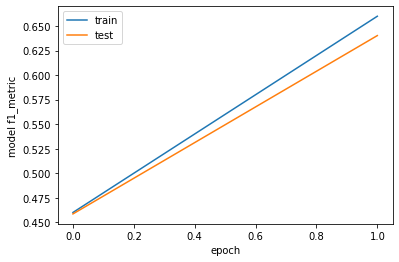

In [16]:
plt.plot(history.history['f1_metric'])
plt.plot(history.history['val_f1_metric'])
plt.ylabel('model f1_metric')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

In [19]:
targets = sequences_data['Injection'].iloc[train_len:].astype(int)
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}).logits
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(targets, y_predicted))

tn, fp, fn, tp = confusion_matrix(targets, y_predicted).ravel()
acc=(tp+tn)/(tp+tn+fp+fn)
prec=tp/(tp+fp)
rec=tp/(tp+fn)
f1=2*prec*rec / (prec+rec)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-score: ", f1)


              precision    recall  f1-score   support

           0       0.82      0.50      0.62      2362
           1       0.61      0.88      0.72      2111

    accuracy                           0.68      4473
   macro avg       0.72      0.69      0.67      4473
weighted avg       0.72      0.68      0.67      4473

Accuracy:  0.678291974066622
Precision:  0.6105263157894737
Recall:  0.8792041686404548
F1-score:  0.7206367695593089
F2-score:  0.8080808080808083


In [138]:
len(Y_test)

7

In [139]:
X = sequences_data["Vulnerability"].tolist()
y = sequences_data["Injection"].tolist()

X = tokenizer(
        text=X[0:],
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

y = np.array(y)

scores=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
values = [np.array([]) for i in range(0, len(scores))]
score_dict = OrderedDict(zip(scores, values))
k=10
f=0
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

nb_epoch = 100
BS = 64
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

for train_index, test_index in kfold.split(X['input_ids'].numpy(), y):
    f = f + 1
    print('fold number= ',f)
    
    X_train_inputs, X_train_attention, X_test_inputs, X_test_attention = np.array(X['input_ids'])[train_index], np.array(X['attention_mask'])[train_index], np.array(X['input_ids'])[test_index], np.array(X['attention_mask'])[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    
#         Y_train = np.array(Y_train)
#         Y_train = Y_train.ravel()
#         Y_test = np.array(Y_test)
#         Y_test = Y_test.ravel()

#         #sampling
#         X_res, Y_res = RandomOverSampler(random_state=seed, sampling_strategy=0.5).fit_resample(X_train, Y_train)
#         #X_res, Y_res = RandomUnderSampler(random_state=seed, sampling_strategy=0.5).fit_resample(X_train, Y_train)

#         #shuffle dataset
#         X_resampled=pd.DataFrame(X_res)
#         Y_resampled=pd.DataFrame(Y_res)
#         newTrain=X_resampled.assign(Label=Y_resampled.values)
#         newTrain = shuffle(newTrain,random_state=seed)
#         X_train=np.array(newTrain.iloc[:, 0:-1 ])
#         X_train=pd.DataFrame(X_train)
#         Y_train=np.array(newTrain.iloc[:, -1 ])
#         Y_train=pd.DataFrame(Y_train)

    model = TFAutoModelForSequenceClassification.from_pretrained(model_variation, num_labels=n_categories)
    # resize model embedding to match new tokenizer
    model.resize_token_embeddings(len(tokenizer))

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[f1_metric]
    )
    
    history = model.fit(
        x = {'input_ids':X_train_inputs, 'attention_mask':X_train_attention},
        y = to_categorical(Y_train.astype(int)),
        validation_data = ({'input_ids':X_test_inputs, 'attention_mask':X_test_attention},
                            to_categorical(Y_test.astype(int))),
        epochs=n_epochs,
        batch_size=batch_size
    )

    predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}).logits
    predictions = np.argmax(predicted, axis=1)
    
    targets = Y_test.astype(int)
    
    accuracy=accuracy_score(targets, predictions)
    precision=precision_score(targets, predictions)
    recall=recall_score(targets, predictions)
    f1=f1_score(targets, predictions)
    roc_auc=roc_auc_score(targets, predictions)
    print(confusion_matrix(targets, predictions, labels=[0, 1]))
    tn, fp, fn, tp = confusion_matrix(targets, predictions).ravel()
    acc = ((tp+tn)/(tp+tn+fp+fn))
    print("Accuracy:%.2f%%"%(acc*100))
    print("Precision:%.2f%%"%(precision*100))
    print("Recall:%.2f%%"%(recall*100))
    print("F1 score:%.2f%%"%(f1*100))
    print("Roc_Auc score:%.2f%%"%(roc_auc*100))
    print(classification_report(targets, predictions))
    del model
    score_dict['accuracy'] = np.append(score_dict['accuracy'], accuracy)
    score_dict['precision'] = np.append(score_dict['precision'], precision)
    score_dict['recall'] = np.append(score_dict['recall'], recall)
    score_dict['f1'] = np.append(score_dict['f1'], f1)
    score_dict['roc_auc'] = np.append(score_dict['roc_auc'], roc_auc)

milli_sec2 = int(round(time.time() * 1000))
print("Cross Validation is completed after", milli_sec2-milli_sec1)

print("accuracy: %.2f%% (%.2f%%)" % (score_dict['accuracy'].mean()*100, score_dict['accuracy'].std()*100))
print("precision: %.2f%% (%.2f%%)" % (score_dict['precision'].mean()*100, score_dict['precision'].std()*100))
print("recall: %.2f%% (%.2f%%)" % (score_dict['recall'].mean()*100, score_dict['recall'].std()*100))
print("f1: %.2f%% (%.2f%%)" % (score_dict['f1'].mean()*100, score_dict['f1'].std()*100))
print("roc_auc: %.2f%% (%.2f%%)" % (score_dict['roc_auc'].mean()*100, score_dict['roc_auc'].std()*100))

Training...
fold number=  1


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


ResourceExhaustedError: in user code:

    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\transformers\modeling_tf_utils.py:1002 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:530 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:636 apply_gradients
        self._create_all_weights(var_list)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:823 _create_all_weights
        self._create_slots(var_list)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\adam.py:126 _create_slots
        self.add_slot(var, 'v')
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:913 add_slot
        initial_value=initial_value)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\variables.py:256 _variable_v2_call
        shape=shape)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3523 creator
        return next_creator(**kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3523 creator
        return next_creator(**kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3523 creator
        return next_creator(**kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\eager\def_function.py:752 variable_capturing_scope
        lifted_initializer_graph=lifted_initializer_graph, **kwds)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\eager\def_function.py:293 __init__
        initial_value = initial_value()
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\initializers\initializers_v2.py:151 __call__
        return array_ops.zeros(shape, dtype)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\array_ops.py:2972 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\array_ops.py:239 fill
        result = gen_array_ops.fill(dims, value, name=name)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:3367 fill
        _ops.raise_from_not_ok_status(e, name)
    C:\Users\iliaskaloup\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\ops.py:6897 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[50267,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


Multi-class Classification: Categorization of all detected vulnerabilities